In [3]:
import bokeh
from bokeh.io import output_notebook
from bokeh.layouts import layout, row, column, widgetbox
from bokeh.models import Label, ColumnDataSource, CustomJS, Rect, HoverTool
from bokeh.plotting import figure, show
from bokeh.models.glyphs import Circle
from bokeh.models.widgets import Select
import data_parser
import spacy
import numpy as np


output_notebook()


Loading BokehJS ...

The codes below read necessary data from csv dataset, and use spacy to generate a document for each movie.

In [4]:

nlp = spacy.load('en')

songs_df = data_parser.parse_csv_data('lyrics.csv', 'ISO-8859-1')
songs_feature_names = data_parser.extract_column_names(songs_df)
#print(songs_feature_names)
songs_dic_list = data_parser.build_row_dic_list(songs_df, songs_feature_names)

In [5]:

artist_list_dic = {}
# Merge the song texts from same artist.
for song in songs_dic_list:
    if song['artist'] in artist_list_dic:
        artist_list_dic[song['artist']]['text'] += song['text']
    else:
        artist_list_dic[song['artist']] = {'artist': song['artist'], 'text': song['text']}
# Generate spacy document for each artist
for k, v in artist_list_dic.items():
    artist_list_dic[k]['doc'] = nlp(v['text'])        



### Data Visualization 1
At first, we want to get a general visual of these words in lyrics, and the wordclound should be a fun way to do that. We can often see a wordcloud image on the internet, it is much popular. so we want to try it by ourselves.

(-0.5, 1999.5, 999.5, -0.5)

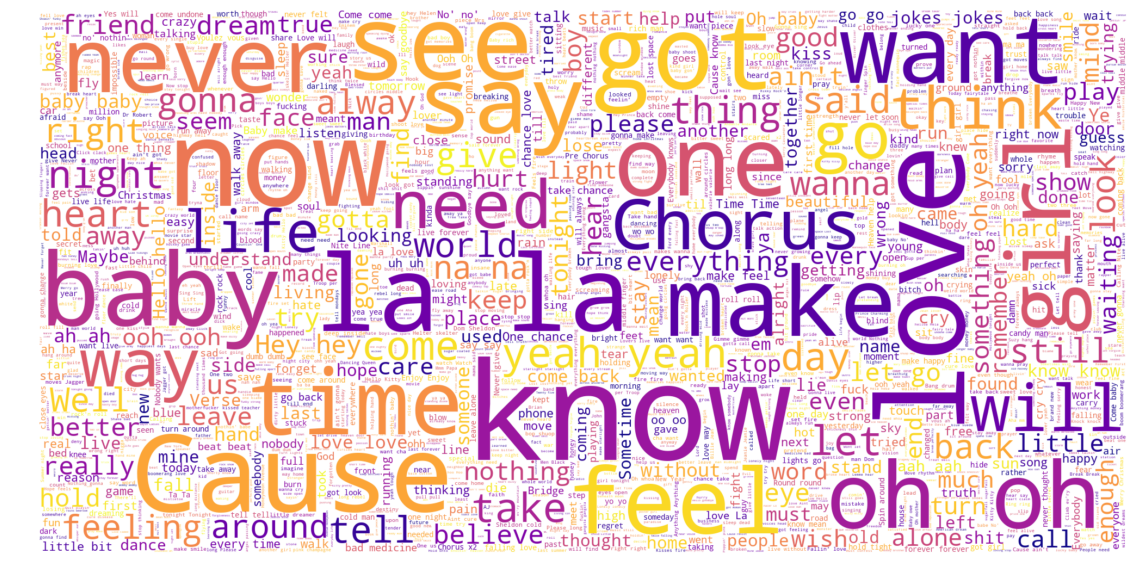

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
text = ""
for k,v in artist_list_dic.items():
    text += str(v["text"])
#text = artist_list_dic["Taylor Swift"]["text"]

# ALL THE LYRICS IN THE $TEXT

# Generate a word cloud image
wc = WordCloud(width=2000,height=1000,max_words=2000,max_font_size=250,colormap="plasma",background_color="white")
wc.generate(text)

plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

### Data visualization 3
In this part, we will divide those lyrics into **2** parts by the gender of the artists. We want to see if artists in different gender will have different tendencies in lyric writing.
We use TF-IDF as the criterion. Generally, it means if a word is more important and more unique to its class, it will has a larger TF-IDF value.

Use sklearn to extract text features and calculate TF-IDF.

In [7]:
# Calculate the TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
lyrics_all_df = data_parser.parse_csv_data('lyrics.csv', 'ISO-8859-1')
mname = ["Bruno Mars", "The Beatles", "Maroon 5", "Backstreet Boys", "Bon Jovi", "Eminem", "Michael Jackson"]
#fname = ["Avril Lavigne", "Ariana Grande", "ABBA", "Britney Spears", "Adele", "Taylor Swift","Christina Aguilera"]
man_lyrics = ""
fem_lyrics = ""
for i in range(len(lyrics_all_df)):
    if mname.count(lyrics_all_df["artist"][i])>0 :
        man_lyrics = man_lyrics + " " + lyrics_all_df["text"][i]
    else:
        fem_lyrics = fem_lyrics + " " + lyrics_all_df["text"][i]
lyric_list = [man_lyrics, fem_lyrics]
count_vect = CountVectorizer(stop_words = 'english')
lyrics_counts = count_vect.fit_transform(lyric_list)
feat = count_vect.get_feature_names()
tf_transformer = TfidfTransformer().fit(lyrics_counts)
lyrics_tfidf = tf_transformer.transform(lyrics_counts)
tfidf = lyrics_tfidf.todense().tolist()

Since we got the TF-IDF, we plot scatter graph. We use hovor and zoom window to get a better view in those dense sample points.

In [8]:
# Draw scatter graph
N = len(tfidf[0])
x = np.array(tfidf[0])
y = np.array(tfidf[1])
colors = ["#%02x%02x%02x" % (int(r), int(g), 100) for r, g in zip(300*x, 300*y)]

source0 = ColumnDataSource({'x': x, 'y': y, 'w': feat})
source1 = ColumnDataSource({'x': [], 'y': [], 'width': [], 'height': []})

jscode="""
    var data = source.data;
    var start = cb_obj.start;
    var end = cb_obj.end;
    data['%s'] = [start + (end - start) / 2];
    data['%s'] = [end - start];
    source.change.emit();
"""

# add hover tool
hover = HoverTool(tooltips=[('Word', '@w')])

p1 = figure(title='Pan and Zoom Here', x_range=(0, 0.32), y_range=(0, 0.32), x_axis_label="Maleness", y_axis_label="Femaleness",
            tools=['box_zoom,wheel_zoom,pan,reset',hover], plot_width=400, plot_height=400)
p1.scatter(x="x", y="y", size=5, fill_color=colors, fill_alpha=0.6, line_color=None, source=source0)

p1.x_range.callback = CustomJS(
        args=dict(source=source1), code=jscode % ('x', 'width'))
p1.y_range.callback = CustomJS(
        args=dict(source=source1), code=jscode % ('y', 'height'))

# add zoom range
p2 = figure(title='See Zoom Window Here', x_range=(0, 0.35), y_range=(0, 0.35), x_axis_label="Maleness", y_axis_label="Femaleness",
            tools='', plot_width=400, plot_height=400)
p2.scatter(x, y, fill_color=colors, fill_alpha=0.6, line_color=None)
rect = Rect(x='x', y='y', width='width', height='height', fill_alpha=0.1,
            line_color='black', fill_color='black')
p2.add_glyph(source1, rect)

layout = row(p1, p2)
show(layout)

/Users/neo/Documents/Codes/690V/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


### Cluster Visualization
Then we want to cluster those songs based on their lyrics' TF-IDF. Calculate every word's TF-IDF for each song, and use KMeans clustering, Spectral clustering, Agglomerative clustering algorithms for clustering.

At first, grab data we need and use sklearn again, but in different way.

In [14]:
artist_label = lyrics_all_df["artist"].tolist()
song_label = lyrics_all_df["song"].tolist()
song_lyric = lyrics_all_df["text"].tolist()

count_vect2 = CountVectorizer(stop_words = 'english')
song_lyric_counts = count_vect2.fit_transform(song_lyric)
feat2 = count_vect2.get_feature_names()
tf_transformer2 = TfidfTransformer().fit(lyrics_counts)
song_lyric_tfidf = tf_transformer2.transform(song_lyric_counts)
#print song_lyric_tfidf.shape

Then use KMeans clustering, Spectral clustering, Agglomerative clustering respectively and get the clustering results.

In [15]:
num_clusters = 5
from sklearn.cluster import KMeans
km = KMeans(n_clusters = num_clusters)
km.fit(song_lyric_tfidf)
#print len(km.labels_)
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters = num_clusters)
sc.fit(song_lyric_tfidf)
#print len(sc.labels_)
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters = num_clusters)
ac.fit(song_lyric_tfidf.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x105e631b8>)

Prepare data for the CustomJS interactive callback model.

In [16]:
labels = [km.labels_.tolist(), sc.labels_.tolist(), ac.labels_.tolist()]
info = [artist_label, song_lable]
tfidf_dense = song_lyric_tfidf.todense().tolist()

top_words = []
cluster_pos = []

for cluster_labels in labels:
    # calculate the average tf-idf
    word_val = []
    for i in range(5):
        word_val.append([0 for i in range(len(feat2))])
    for i in range(len(cluster_labels)):
        for j in range(len(feat2)):
            word_val[cluster_labels[i]][j] += tfidf_dense[i][j]

    # Pick 5 most important words in each cluster
    max_num = 5
    word_idx = []
    word_labels = []
    for i in range(num_clusters):
        word_idx.append([])
    for i in range(num_clusters):
        arr = list(word_val[i])
        for j in range(max_num):
            idx = arr.index(max(arr))
            word_idx[i].append(idx)
            arr[idx] = 0
    for i in range(num_clusters):
        s = ''
        for j in word_idx[i]:
            s += feat[j]
            s += ' / '
        word_labels.append(s)
    
    top_words.append(word_labels)

    from sklearn.metrics.pairwise import cosine_similarity
    dist = 1 - cosine_similarity(song_lyric_tfidf)
    
    from sklearn.manifold import MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)
    xs, ys = pos[:, 0], pos[:, 1]
    #print len(ys)
    
    pos = []
    for i in range(num_clusters):
        pos.append([])
    for i in range(num_clusters):
        pos[i].append([float("nan") for j in range(len(cluster_labels))])
        pos[i].append([float("nan") for j in range(len(cluster_labels))])
    for i in range(len(cluster_labels)):
        L = cluster_labels[i]
        pos[L][0][i] = xs[i]
        pos[L][1][i] = ys[i]
    
    cluster_pos.append(pos)

Draw those clusters. Use hover and select widget to get a better view and comparison.

In [17]:
x_attr = ["x0","x1","x2","x3","x4"]
y_attr = ["y0","y1","y2","y3","y4"]
data_cluster = {}
for i in range(num_clusters):
    data_cluster[x_attr[i]] = cluster_pos[0][i][0]
    data_cluster[y_attr[i]] = cluster_pos[0][i][1]

data_cluster["artist"] = artist_label
data_cluster["song"] = song_label
cache = [cluster_pos, top_words]
for i in range(len(labels[0])-2):
    cache.append([]) 
data_cluster["cache"] = cache

source = ColumnDataSource(data=data_cluster)

# add hover tool
hover2 = HoverTool(tooltips=[('Artist', '@artist'),("Song","@song")])

plot2 = figure(plot_width=900, plot_height=600, tools = [hover2])
plot2.background_fill_color = "lightgrey"
plot2.background_fill_alpha = 0.2

plot2.circle('x0' ,'y0' ,source=source, size=8, color="blue", alpha=0.5)
plot2.circle('x1' ,'y1' ,source=source, size=8, color="red", alpha=0.5)
plot2.circle('x2' ,'y2' ,source=source, size=8, color="green", alpha=0.5)
plot2.circle('x3' ,'y3' ,source=source, size=8, color="yellow", alpha=0.5)
plot2.circle('x4' ,'y4' ,source=source, size=8, color="purple", alpha=0.5)

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var name = cb_obj.value;
    switch(name){
    case "KMeans":
        for (i = 0; i < data["x0"].length; i++) {
            data["x0"][i] = data["cache"][0][0][0][0][i]
            data["y0"][i] = data["cache"][0][0][0][1][i]
            data["x1"][i] = data["cache"][0][0][1][0][i]
            data["y1"][i] = data["cache"][0][0][1][1][i]
            data["x2"][i] = data["cache"][0][0][2][0][i]
            data["y2"][i] = data["cache"][0][0][2][1][i]
            data["x3"][i] = data["cache"][0][0][3][0][i]
            data["y3"][i] = data["cache"][0][0][3][1][i]
            data["x4"][i] = data["cache"][0][0][4][0][i]
            data["y4"][i] = data["cache"][0][0][4][1][i]
        }break;
    case "Spectral":
        for (i = 0; i < data["x0"].length; i++) {
            data["x0"][i] = data["cache"][0][1][0][0][i]
            data["y0"][i] = data["cache"][0][1][0][1][i]
            data["x1"][i] = data["cache"][0][1][1][0][i]
            data["y1"][i] = data["cache"][0][1][1][1][i]
            data["x2"][i] = data["cache"][0][1][2][0][i]
            data["y2"][i] = data["cache"][0][1][2][1][i]
            data["x3"][i] = data["cache"][0][1][3][0][i]
            data["y3"][i] = data["cache"][0][1][3][1][i]
            data["x4"][i] = data["cache"][0][1][4][0][i]
            data["y4"][i] = data["cache"][0][1][4][1][i]
        }break;
    case "Agglomerative":
        for (i = 0; i < data["x0"].length; i++) {
            data["x0"][i] = data["cache"][0][2][0][0][i]
            data["y0"][i] = data["cache"][0][2][0][1][i]
            data["x1"][i] = data["cache"][0][2][1][0][i]
            data["y1"][i] = data["cache"][0][2][1][1][i]
            data["x2"][i] = data["cache"][0][2][2][0][i]
            data["y2"][i] = data["cache"][0][2][2][1][i]
            data["x3"][i] = data["cache"][0][2][3][0][i]
            data["y3"][i] = data["cache"][0][2][3][1][i]
            data["x4"][i] = data["cache"][0][2][4][0][i]
            data["y4"][i] = data["cache"][0][2][4][1][i]
        }break;
    }
    source.change.emit();
""")

cluster_select = Select(title="Select Cluster Algorithm:", value="KMeans", options=["KMeans","Spectral","Agglomerative"])
cluster_select.js_on_change('value', callback)

show(column(plot2,widgetbox(cluster_select)))